In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 6.8 MB 29.7 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 37.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification, glue_convert_examples_to_features

In [ ]:
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model as vizu
import pandas as pd
import os
import re
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/mysky/Result_29.csv")
data['comp_from_name'] = data.comp_from_name.astype(str)
data['comp_from_type'] = data.comp_from_type.astype(str)
data['service_details'] = data.service_details.astype(str)
data['cost_root_id'] = data.cost_root_id.astype(int)
data

,id,doc_date,cost_ids,cost_root_id,cost_variant_id,curr_value,curr_id,comp_from_id,comp_from_name,comp_from_type,comp_from_agent,comp_from_operator,comp_from_manufaturer,comp_to_id,comp_to_name,service_details,aircrat_id,aicraft_size
0,854171,2020-08-18,{70},70,1,10.50,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,WASTE REMOVING (PER BAG) (V-3),173,medium
1,854164,2020-08-18,{70},70,1,66.14,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,LAUNDRY,173,medium
2,854170,2020-08-18,{43},43,1,265.00,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,TOWING UP TO 500M (V-3),173,medium
3,854172,2020-08-18,{71},71,1,300.00,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,LAVATORY SERVICE (V-3),173,medium
4,854183,2020-08-18,{73},73,1,85.00,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,AIRCRAFT TECHNICAL ASSISTANCE PER DEP (V-3),173,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550227,862509,2020-10-14,{59},59,1,2.00,1,4360,Universal Aviation Italy S.r.l.,company,False,False,False,5471,Premium Jet AG,Additional passenger charge L 350/2003,171,medium
550228,862516,2020-10-14,{59},59,1,1.00,1,4360,Universal Aviation Italy S.r.l.,company,False,False,False,5471,Premium Jet AG,Additional passenger charge L296/2006,171,medium
550229,862525,2020-10-14,{59},59,1,4.00,1,4360,Universal Aviation Italy S.r.l.,company,False,False,False,5471,Premium Jet AG,Additional passenger charge L92/2012,171,medium
550230,763683,2018-12-26,{130},130,1,500.00,1,4602,Jet Source FZE,independent,False,False,False,6016,Flights Holdings Limited,5 / Business trip / Movement from Homebase to ...,191,medium


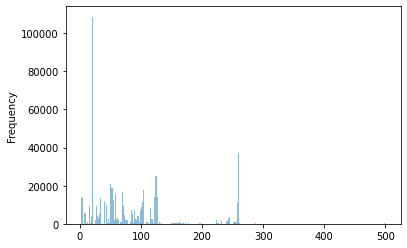

In [ ]:
data.cost_root_id.plot.hist(bins=270, alpha=0.5)

In [ ]:
value_counts = data.cost_root_id.value_counts()
value_counts

22     57321
21     51363
259    37283
104    16584
124    15036
       ...  
230        1
148        1
283        1
288        1
80         1
Name: cost_root_id, Length: 233, dtype: int64

In [ ]:
value_counts.where(value_counts < 1000)

22     NaN
21     NaN
259    NaN
104    NaN
124    NaN
      ... 
230    1.0
148    1.0
283    1.0
288    1.0
80     1.0
Name: cost_root_id, Length: 233, dtype: float64

In [ ]:
value_counts.loc[value_counts < 100]

122    95
167    90
157    88
54     84
139    77
       ..
230     1
148     1
283     1
288     1
80      1
Name: cost_root_id, Length: 100, dtype: int64

In [ ]:
ignored_cost_articles = value_counts.loc[value_counts < 100].index.to_list()
ignored_cost_articles[:2]

[122, 167]

In [ ]:
data_lim = data.copy()
data_lim.loc[data['cost_root_id'].isin(ignored_cost_articles), 'cost_root_id'] = 1000
data_lim.cost_root_id.unique()

array([  70,   43,   71,   73,   55,   82,    4,  101,  116,   30,   22,
          9,   32,   96,   35,   21,  100,  258,  125,  104,   52,  259,
        123,   62,   85,   44,   59,  243,  124,   51,   53,   34,   50,
         99,   39,   91,   20,   84,   47,   16,   69,   90,   94,    3,
         72,   98,   48,   33,  244,   27,   74,   75,   58,  127,   29,
         45,   56,   15,   97,   25,   89,   26,  103,  255,  105,  130,
         87,   61,   83,   60,   68,   78,  262,   57,  225,  112,  224,
         64,  117,  226,  294,   40,  115,  254,  239,  253,  126, 1000,
         67,  252,   49,   86,  287,  500,  109,   12,   41,   92,  257,
        196,  241,  232,  120,  159,  171,  149,  131,  165,   77,   76,
        132,  242,  164,  152,  169,  151,   95,  134,  256,  121,  178,
        155,  129,  156,  173,   63,  160,  163,  162,   10,  158,   18,
        166,  153])

In [ ]:
len(data_lim.cost_root_id.unique())

134

In [ ]:
len(data.cost_root_id.unique())

233

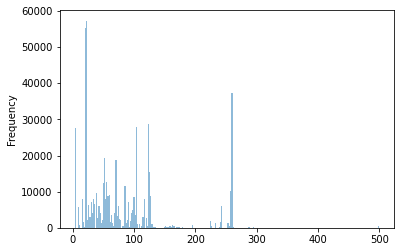

In [ ]:
data_lim = data.loc[~data['cost_root_id'].isin(ignored_cost_articles)]
data_lim.cost_root_id.plot.hist(bins=270, alpha=0.5)

In [ ]:
data_lim.cost_root_id.value_counts(normalize=True)

22     0.104670
21     0.093791
259    0.068080
104    0.030283
124    0.027456
         ...   
166    0.000205
239    0.000203
294    0.000199
134    0.000194
153    0.000188
Name: cost_root_id, Length: 133, dtype: float64

In [ ]:
len(data_lim.cost_root_id.unique())

134

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 (data_lim.cost_root_id.unique()),
                                                 data_lim.cost_root_id.values)
class_weights

array([ 0.32087278,  0.67336979,  0.68551068,  0.88002764,  0.33495464,
       10.08896549,  0.30027122,  1.1570045 ,  0.78168836,  1.33839927,
        0.07163533,  0.73403807,  0.9730353 ,  0.98140749,  0.63211345,
        0.07994488,  0.7794626 ,  0.39897094,  0.39986454,  0.24760064,
        0.3774436 ,  0.11013623,  0.29850312,  1.35028246,  0.89381997,
        1.06323381,  0.49341612,  1.56725533,  0.27309184,  0.49187937,
        0.51027823,  0.58946439,  0.33316097,  1.26461625,  0.42938502,
        1.67943107,  1.03639802,  0.58401493,  3.22815169,  2.77821986,
        1.08314665,  0.85421447,  2.28503559,  0.29186218,  1.24129654,
        1.00543804,  2.8260213 ,  4.06555342,  1.19679655,  1.38536065,
        3.2155121 ,  4.37295948,  0.57269302,  0.46080226,  0.99351777,
       18.41349307, 10.66547781,  0.51819901,  4.57771344,  1.88444651,
        1.85131152,  0.65406323,  0.36370318,  6.40594221,  3.48574614,
        4.85367489,  4.277301  ,  2.68029305,  8.03563396,  5.65

In [ ]:
data_lim.cost_root_id.unique()

array([  70,   43,   71,   73,   55,   82,    4,  101,  116,   30,   22,
          9,   32,   96,   35,   21,  100,  258,  125,  104,   52,  259,
        123,   62,   85,   44,   59,  243,  124,   51,   53,   34,   50,
         99,   39,   91,   20,   84,   47,   16,   69,   90,   94,    3,
         72,   98,   48,   33,  244,   27,   74,   75,   58,  127,   29,
         45,   56,   15,   97,   25,   89,   26,  103,  255,  105,  130,
         87,   61,   83,   60,   68,   78,  262,   57,  225,  112,  224,
         64,  117,  226,  294,   40,  115,  254,  239,  253,  126, 1000,
         67,  252,   49,   86,  287,  500,  109,   12,   41,   92,  257,
        196,  241,  232,  120,  159,  171,  149,  131,  165,   77,   76,
        132,  242,  164,  152,  169,  151,   95,  134,  256,  121,  178,
        155,  129,  156,  173,   63,  160,  163,  162,   10,  158,   18,
        166,  153])

In [ ]:
len(class_weights)

134

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder = LabelEncoder()
trafomed_label = encoder.fit_transform(data_lim.cost_root_id.unique())
print(len(trafomed_label))


134


In [ ]:
data_lim

,id,doc_date,cost_ids,cost_root_id,cost_variant_id,curr_value,curr_id,comp_from_id,comp_from_name,comp_from_type,comp_from_agent,comp_from_operator,comp_from_manufaturer,comp_to_id,comp_to_name,service_details,aircrat_id,aicraft_size
0,854171,2020-08-18,{70},70,1,10.50,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,WASTE REMOVING (PER BAG) (V-3),173,medium
1,854164,2020-08-18,{70},70,1,66.14,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,LAUNDRY,173,medium
2,854170,2020-08-18,{43},43,1,265.00,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,TOWING UP TO 500M (V-3),173,medium
3,854172,2020-08-18,{71},71,1,300.00,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,LAVATORY SERVICE (V-3),173,medium
4,854183,2020-08-18,{73},73,1,85.00,1,158,SBA Flight Support Services Ltd,independent,True,True,False,3605,Jet Capital Aviation S.A.,AIRCRAFT TECHNICAL ASSISTANCE PER DEP (V-3),173,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550227,862509,2020-10-14,{59},59,1,2.00,1,4360,Universal Aviation Italy S.r.l.,company,False,False,False,5471,Premium Jet AG,Additional passenger charge L 350/2003,171,medium
550228,862516,2020-10-14,{59},59,1,1.00,1,4360,Universal Aviation Italy S.r.l.,company,False,False,False,5471,Premium Jet AG,Additional passenger charge L296/2006,171,medium
550229,862525,2020-10-14,{59},59,1,4.00,1,4360,Universal Aviation Italy S.r.l.,company,False,False,False,5471,Premium Jet AG,Additional passenger charge L92/2012,171,medium
550230,763683,2018-12-26,{130},130,1,500.00,1,4602,Jet Source FZE,independent,False,False,False,6016,Flights Holdings Limited,5 / Business trip / Movement from Homebase to ...,191,medium


In [ ]:
encoder.fit_transform(data_lim.cost_root_id)

array([46, 46, 23, ..., 37, 89,  0])

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
encoder.fit_transform(data_lim.cost_root_id)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
from keras.utils.np_utils import to_categorical
categorical_labels = to_categorical(data_lim.cost_root_id.values, num_classes=None)
categorical_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
data_lim.cost_root_id.unique()

array([ 70,  43,  71,  73,  55,  82,   4, 101, 116,  30,  22,   9,  32,
        96,  35,  21, 100, 258, 125, 104,  52, 259, 123,  62,  85,  44,
        59, 243, 124,  51,  53,  34,  50,  99,  39,  91,  20,  84,  47,
        16,  69,  90,  94,   3,  72,  98,  48,  33, 244,  27,  74,  75,
        58, 127,  29,  45,  56,  15,  97,  25,  89,  26, 103, 255, 105,
       130,  87,  61,  83,  60,  68,  78, 262,  57, 225, 112, 224,  64,
       117, 226, 294,  40, 115, 254, 239, 253, 126,  67, 252,  49,  86,
       287, 500, 109,  12,  41,  92, 257, 196, 241, 232, 120, 159, 171,
       149, 131, 165,  77,  76, 132, 242, 164, 152, 169, 151,  95, 134,
       256, 121, 178, 155, 129, 156, 173,  63, 160, 163, 162,  10, 158,
        18, 166, 153])

In [ ]:
def cost_articls_to_classes(data, ignored_cost_articles):
  ids_list = {}


In [ ]:
X_train, X_val = train_test_split(data_lim, test_size=0.2, random_state=42)

In [ ]:
train = data_lim.sample(frac=0.8,random_state=0)
val = data_lim.drop(index=train.index)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train["service_details"], train["cost_root_id"]))
val_ds = tf.data.Dataset.from_tensor_slices((val["service_details"], val["cost_root_id"]))

In [ ]:
batch_size = 8

In [ ]:
def clear_punct(entry):
    line = tf.strings.regex_replace(entry['sentence'], "\.\.+", "\.", replace_global=True)
    line = tf.strings.regex_replace(line, "\s\s+", "\s", replace_global=True)
    line = tf.strings.regex_replace(line, "\\n", "", replace_global=True)
    entry['sentence'] = line
    return features

In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
      # print(label)
      return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label

In [ ]:
def encode_examples(ds, encoder, limit=-1):
    
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)
    max_length_test = 64
    for line, label in tfds.as_numpy(ds):
      
      bert_input = tokenizer.encode_plus(
                      line.decode(),                      
                      add_special_tokens = True,
                      max_length = max_length_test,
                      padding='max_length',
                      return_attention_mask = True,
                      truncation=True
            )
    
      input_ids_list.append(bert_input['input_ids'])
      token_type_ids_list.append(bert_input['token_type_ids'])
      attention_mask_list.append(bert_input['attention_mask'])
      label_list.append(label)
    
    print(encoder.transform(label_list).shape)
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, encoder.transform(label_list))).map(map_example_to_dict)

In [ ]:
class Cat_to_labels:
  def __init__(self, labels):
    self.n_labels = len(labels)
    self.labels_dict = {}
    for i, label in enumerate(labels):
      self.labels_dict[label] = i

  def fit_transform(self, labels):


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

In [ ]:
train_ds.take(1000)

<TakeDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [ ]:
encoder = LabelBinarizer()

In [ ]:
encoder.fit(data_lim.cost_root_id.unique())

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [ ]:
len(encoder.classes_)

134

In [ ]:
encoder.transform([1, 6])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [ ]:
len([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

134

In [ ]:
train_ds_encoded = encode_examples(train_ds.take(1000), encoder)
val_ds_encoded = encode_examples(val_ds.take(1000), encoder)

train_ds_encoded = train_ds_encoded.shuffle(1000).batch(batch_size)
val_ds_encoded = val_ds_encoded.shuffle(1000).batch(batch_size)

(1000, 134)
(1000, 134)


In [ ]:
train_ds_encoded = encode_examples(train_ds, encoder)
val_ds_encoded = encode_examples(val_ds, encoder)

train_ds_encoded = train_ds_encoded.shuffle(10000).batch(batch_size)
val_ds_encoded = val_ds_encoded.shuffle(10000).batch(batch_size)

(440186, 134)
(110046, 134)


In [ ]:
type(train_ds_encoded)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
for sample in train_ds_encoded.take(1):
  print(sample)

({'input_ids': <tf.Tensor: shape=(8, 64), dtype=int32, numpy=
array([[  101, 10288,   119, 10454,   119, 10520, 18203, 21205,   113,
        14956, 14013, 10900, 45158, 11388,   118,   149, 53806, 12027,
          114,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  101, 10264,   120, 10717, 10912,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,

In [ ]:
len([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

100

In [ ]:
len(data_lim.cost_root_id.unique())

134

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=len(data_lim.cost_root_id.unique()))

l_r= 3e-5
n_epochs = 100

optimizer = tf.keras.optimizers.Adam(learning_rate=l_r, epsilon=1e-08)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=metric)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  327594    
Total params: 167,684,010
Trainable params: 167,684,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0.001,
    verbose=1,
    patience=3,
    restore_best_weights=True)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'content/gdrive/My Drive/mysky/models/bert.{epoch:02d}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    period=1) 

In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

13G


In [ ]:
class_weights
class_weight_new = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_new

{0: 0.32087277918448703,
 1: 0.673369786032122,
 2: 0.6855106769989784,
 3: 0.8800276372104331,
 4: 0.3349546419140126,
 5: 10.088965491950567,
 6: 0.3002712215885836,
 7: 1.1570044956956553,
 8: 0.7816883600273902,
 9: 1.3383992683259063,
 10: 0.07163533356403204,
 11: 0.7340380685062353,
 12: 0.9730352974464173,
 13: 0.9814074940783654,
 14: 0.632113447540622,
 15: 0.0799448816312108,
 16: 0.7794625959043053,
 17: 0.39897094395879135,
 18: 0.3998645394121999,
 19: 0.24760063647032565,
 20: 0.37744360283333767,
 21: 0.11013622710682833,
 22: 0.29850312265366974,
 23: 1.350282458146623,
 24: 0.8938199728393297,
 25: 1.0632338050812742,
 26: 0.4934161205508148,
 27: 1.5672553264213285,
 28: 0.27309184325777336,
 29: 0.49187936694104945,
 30: 0.5102782347736896,
 31: 0.5894643920792249,
 32: 0.33316096999788075,
 33: 1.2646162473741547,
 34: 0.42938502093735026,
 35: 1.6794310655312394,
 36: 1.0363980199959315,
 37: 0.5840149274959295,
 38: 3.2281516943583966,
 39: 2.7782198614505282,
 4

In [ ]:
history = model.fit(train_ds_encoded, epochs=n_epochs, validation_data=val_ds_encoded, callbacks=[checkpoint, early_stopping],
                    class_weight = class_weight_new)

Epoch 1/100
25585/55024 [============>.................] - ETA: 1:11:36 - loss: 3.0512 - accuracy: 0.7198

KeyboardInterrupt: ignored

In [ ]:
model.save_weights("gdrive/My Drive/Colab Notebooks/models/bert.h5")

In [ ]:
model_predictions = model.predict(val_ds_encoded)
# model_predictions

In [ ]:
labels = None
for element in val_ds_encoded.as_numpy_iterator():
  if labels is None:
    labels = tf.convert_to_tensor(element[1])
  else:
    labels = tf.concat([labels, tf.convert_to_tensor(element[1])], 0)

In [ ]:
labels.shape

In [ ]:
predictions = None
for element in model_predictions[0]:
  # print(tf.convert_to_tensor(element).shape)
  if predictions is None:
    predictions = [tf.convert_to_tensor(element)]
  else:
    predictions = tf.concat([predictions, [tf.convert_to_tensor(element)]], 0)
predictions.shape

In [ ]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(labels, predictions)
m.result().numpy()

In [ ]:
predicted_categories = tf.argmax(predictions, axis=1)
predicted_categories

In [ ]:
labels_categories = tf.argmax(labels, axis=1)
labels_categories

In [ ]:
matrix = confusion_matrix(labels_categories, predicted_categories)
accuracies  = matrix.diagonal()/matrix.sum(axis=1)
accuracies

In [ ]:
labels_mapping = {i:label for i, label in enumerate(encoder.classes_)}
len(labels_mapping)

In [ ]:
for i, accuracy in enumerate(accuracies):
  print(f"Label {labels_mapping[i]} : accuracy {accuracy}")

In [ ]:
np.argsort(matrix[109], axis=-1, kind='quicksort')[::-1][:3]

In [ ]:
labels_mapping_reversed = {label:i for i, label in enumerate(encoder.classes_)}

In [ ]:
for el in [117, 133, 111]:
  print(labels_mapping[el])